# COMP9033 - Data Analytics Lab 06: Linear regression
## Introduction

This week's lab focuses on anomaly detection using linear regression. At the end of the lab, you should be able to use `scikit-learn` to:

- Create a linear regression model using the least squares technique.
- Use the model to predict new values.
- Measure the accuracy of the model.
- Use scaling and polynomial feature generation to create new predictors and improve model accuracy.

### Getting started

Let's start by importing the packages we need. This week, we're going to use the `linear_model` subpackage from `scikit-learn` to build linear regression models using the least squares technique. We're also going to need the `preprocessing` subpackage to perform feature scaling and polynomial feature generation and the `pipeline` package to tie it all together.

In [1]:
%matplotlib inline
import pandas as pd

from math import sqrt # We'll need this later

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Next, let's load the data. Write the path to your `server_load_historical.csv` file in the cell below:

In [2]:
path = "data/server_load_historical.csv"

The data we're loading is simulated network interface load data (in Gb/s) from a front end web server:

In [3]:
df = pd.read_csv(path, parse_dates=True, index_col="time")
df.head()

,server_load
time,
2017-03-01 00:00:00,17.195266
2017-03-01 00:05:00,22.716169
2017-03-01 00:10:00,9.441414
2017-03-01 00:15:00,32.120720
2017-03-01 00:20:00,20.047028


The data is noisy due to fluctuating user logins and data transfers and follows a seasonal trend:

       server_load
count   288.000000
mean     20.731350
std       8.058717
min      -1.233527
25%      15.375479
50%      20.501729
75%      26.670758
max      39.551862


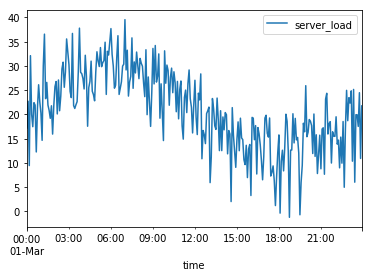

In [4]:
print(df.describe()) # Print summary statistics
df.plot(); # Plot the data

## Data modelling

Let's build a linear regression model of the server load data. `scikit-learn` supports linear regression via the <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model">`linear_model`</a> subpackage. This subpackage supports least squares regression, lasso regression and ridge regression, as well as many other varieties. Let's use least squares to build our model. We can do this using the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`LinearRegression`</a> class.

Least squares linear regression aims to find good values of $\beta_i,~ i \in [0, p],$  to predict our target variable as

\begin{align}
    \hat{y} = \beta_0 + \sum_{i=1}^{p} \beta_i x_i.
\end{align}

In our case, we want to use our existing knowledge of server load to predict how it will behave in the future. Specifically, we're interested in modelling the behaviour of the server load over time. Therefore, our predictor variable will be the time of day and our target variable will be the server load.

To get the time of day, we can subtract the first timestamp in our index from each timestamp in our index and convert the results to integer values:

In [5]:
time = (df.index - df.index[0]).astype('int') # Computes the time from midnight in nanoseconds

Next, we construct our feature matrix, $\mathbf{X}$, using our predictor values:

In [6]:
X = pd.DataFrame({'time': time}, index=df.index)
X.head()

,time
time,
2017-03-01 00:00:00,0
2017-03-01 00:05:00,300000000000
2017-03-01 00:10:00,600000000000
2017-03-01 00:15:00,900000000000
2017-03-01 00:20:00,1200000000000


And we set our target variable, $\mathbf{y}$, to be the server load data:

In [7]:
y = df['server_load']
y.head()

time
2017-03-01 00:00:00    17.195266
2017-03-01 00:05:00    22.716169
2017-03-01 00:10:00     9.441414
2017-03-01 00:15:00    32.120720
2017-03-01 00:20:00    20.047028
Name: server_load, dtype: float64

Let's use hold out validation to estimate our model error. We can use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method (just like last week's lab) to split the data into a training set and a test set. Let's use 20% of the data for testing:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Now, we can build a model by fitting our estimator on the training data:

In [9]:
ols = LinearRegression() # ols = Ordinary Least Squares
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

We can examine our model intercept ($\beta_0$) and coefficients ($\beta_i, i \in [1, p]$) using the `intercept_` and `coef_` attributes of the fitted model, like this:

In [10]:
print('Intercept: %s' % ols.intercept_)
print('Coefficients: %s' % ols.coef_)

Intercept: 29.1295499686
Coefficients: [ -1.96865779e-13]


As we have just one predictor (the time of day), we have only a single coefficient.

We can then use our model to make predictions about the test data and use these predictions to estimate the model error. Let's compute the mean absolute error (MAE) and the root mean squared error (RMSE).

> **Note:** The `mean_squared_error` (MSE) method used in the cell below returns a number that is the square of the RMSE, i.e.

\begin{align}
    \text{MSE} = \text{RMSE}^2 = \frac{1}{n} \sum_{i=1}^{n} \epsilon_i^2.
\end{align}

> Consequently, the MSE has units that are the square of the units of the RMSE. For instance, if our target variable is measured in metres, then the MAE and RMSE will have units of meters, while the MSE will have units of metres *squared*. If we want to make comparisons between the model error and the target variable, then we should use an error measure that has the same units as the target (e.g. MAE, RMSE).

MAE: 5.86 Gb/s
RMSE: 6.91 Gb/s


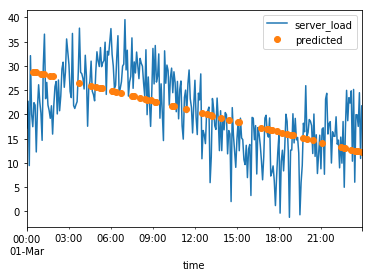

In [11]:
# Make predictions about the test data
y_pred = ols.predict(X_test)

# Print error measurements
print('MAE: %.2f Gb/s' % mean_absolute_error(y_test, y_pred))
print('RMSE: %.2f Gb/s' % sqrt(mean_squared_error(y_test, y_pred))) # Use sqrt to get the RMSE from the MSE

# Plot the predictions
ax = df.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_test.index)
predicted.plot(ax=ax, marker='o', linewidth=0);

This fit isn't good at all! This is because the relationship between server load and time is *non-linear*, and linear regression can only model *linear* relationships. However, we can compensate for this by including *polynomial features* in our model. These are transformations of the input features, like $x, x^2, x^3$. In `scikit-learn`, we can generate these automatically using the [`PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) class.

Before generating polynomial features, we should first make sure that our features are *centered*, i.e. that they have zero mean. This is a requirement when using polynomial features with linear regression algorithms. In `scikit-learn`, we can do this using the [`StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) class.

We can constuct a *pipeline* to manage the order of the preprocessing stages. A pipeline is simply a chain of preprocessing steps coupled to a model builder. In `scikit-learn`, pipelines are supported via the [`pipeline`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) subpackage. We can construct a pipeline consisting of a `StandardScaler`, a `PolynomialFeatures` generator and a `LinearRegression` model builder like this:

In [12]:
pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=4, include_bias=False), # Generate t, t^2, t^3, t^4
    LinearRegression()
)

The pipeline works just like a normal scikit-learn estimator, i.e. it supports the `fit` and `predict` methods. As a result, we can just treat the pipeline as if it's a standard scikit-learn estimator object, fitting our data using the `fit` method and predicting new outcomes using the `predict` method.

Using the pipeline ensures that our polynomial features are scaled and generated automatically every time, even if we change the input data. From a progamming point of view, this can be a very flexible and powerful tool: we can just construct a single pipeline object and reuse it to predict new data again and again.

Let's train the pipeline on our data:

In [13]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=4, include_bias=False, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

We can access the steps of the pipeline using its `named_steps` attribute. This is just a Python `dict` object, whose keys consist of the names of the steps in *lowercase*.

For instance, we can print the regression model intercept and coefficients like this:

In [14]:
# Print the model coefficients
ols = pipeline.named_steps['linearregression']
print('Intercept: %s' % ols.intercept_)
print('Coefficients: %s' % ols.coef_) # Coefficients for t, t^2, t^3, t^4

Intercept: 21.3012400617
Coefficients: [-13.81884477  -0.74487067   4.97882239   0.07855897]


Let's see how good our new model is:

MAE: 4.42 Gb/s
RMSE: 5.56 Gb/s


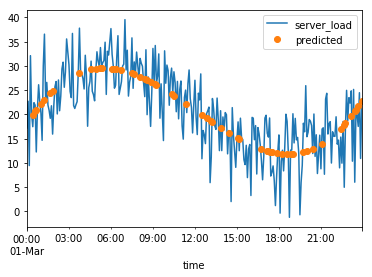

In [15]:
# Make predictions about the test data
y_pred = pipeline.predict(X_test)

# Print error measurements
print('MAE: %.2f Gb/s' % mean_absolute_error(y_test, y_pred))
print('RMSE: %.2f Gb/s' % sqrt(mean_squared_error(y_test, y_pred))) # Use sqrt to get the RMSE from the MSE

# Plot the predictions
ax = df.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_test.index)
predicted.plot(ax=ax, marker='o', linewidth=0);

As can be seen, the model has learned the trend of the server load data. We can use this to construct an anomaly detector to automatically flag unusual server load activity in the future.

## Anomaly detection

Now that we have a model, we can use it to detect anomalies in new data. Let's load some data where the server experiences an unusual load for the time of day:

In [16]:
path = 'data/server_load_new.csv'

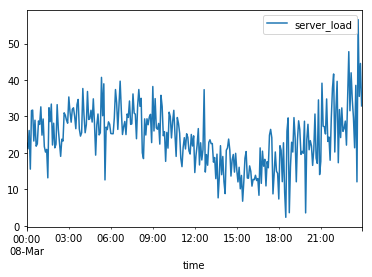

In [17]:
df2 = pd.read_csv(path, parse_dates=True, index_col='time')
df2.plot();

We can extract our predictor matrix and our target variable just like before:

In [18]:
X_new = pd.DataFrame({'time': (df2.index - df2.index[0]).astype('int')}, index=df2.index)
y_new = df2['server_load']

We can see the difference between the new data and the model by plotting like before:

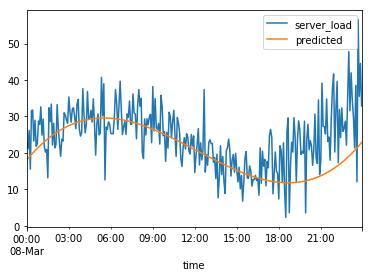

In [19]:
# Make predictions about the test data
y_pred = pipeline.predict(X_new)

# Plot the predictions
ax = df2.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_new.index)
predicted.plot(ax=ax);

While it is easy to gauge the anomaly visually, ideally an automatic system would detect it for us. This way, we don't have to micro-manage systems; instead, we can just sit back and wait to be alerted. Let's use a standard score test to find observations that are extremely different from what we expect.

The standard score test works by finding observations ($x_i$) in a sample ($X = \{x_1, x_2, \ldots, x_n\}$) that are more than a given number ($\lambda$) of standard deviations ($\sigma_x$) away from the average value ($\bar{x}$), i.e.

\begin{align}
    \left| z(x_i) \right| > \lambda,
\end{align}
where
\begin{align}
    z(x_i) = \frac{x_i - \bar{x}}{\sigma_x}.
\end{align}

We can combine the equations above to work out the range of non-outlying observations, i.e.

\begin{align}
    x_i \in [\bar{x} - \lambda \sigma_x, \bar{x} + \lambda \sigma_x].
\end{align}

Consequently, any observation that lies outside this range can be considered an anomaly.

In our case, we want to detect observations that deviate significantly from the predicted value given by our model. We can do this by checking for model prediction errors that lie outside the range of non-outlying prediction errors. Let's use $\lambda = 3$ to find instances where the model prediction error is more than three standard deviations from the mean prediction error:

In [20]:
# The prediction error on the training set represents the "normal" error we should expect
error = y_train - pipeline.predict(X_train)

# Compute the range of non-outlying prediction errors
l = 3 # l = lambda
min_error = error.mean() - l * error.std()
max_error = error.mean() + l * error.std()

Next, we compute the prediction error on the new data:

In [21]:
error = y_new - pipeline.predict(X_new)

Plotting the output, we can see exactly where an automated system would have shown us that an anomaly was occurring:

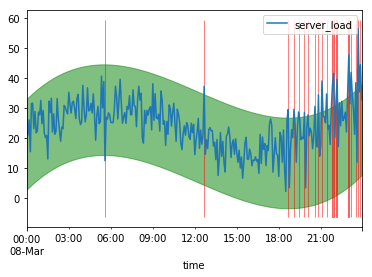

In [22]:
ax = df2.plot()
ax.fill_between(df2.index, y_pred + min_error, y_pred + max_error, color='green', alpha=0.5)
ax.fill_between(df2.index, ax.get_ylim()[0], ax.get_ylim()[1], color='red', alpha=0.5,
                where=(error < min_error) | (error > max_error));

As can be seen, the system detects the server load anomaly that occurs after 18:00, but it also catches two other anomalies, one just before 06:00 and the other just after 12:00. In these cases, the anomaly detector has misclassified the data as anomalous (i.e. it has made a mistake). We can increase our value of $\lambda$ to ensure that this doesn't happen, at the cost of detecting fewer genuine anomalies. Alternatively, we can accept that the error rate is small enough to be tolerable, and perhaps suppress alerts for transient anomalies with short lifespans.